# Analysis of Mira

### Preamble
Imports and constants

In [1]:
from py_fish.plotting import plot_speed_profile, plot_profiles
from py_fish.operation import (
    speed_profile_from_data,
    extract_transit_speed,
    distance_from_profile,
    total_consumption_from_profile,
)
from py_fish.data import load_one_day
from py_fish.loads import calculate_propulsion_power
from py_fish.utils import components_to_profile

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import os
import folium
from scipy.ndimage import uniform_filter1d

In [2]:
ENGINE_RATING = 167.0
LENGTH = 11.00
BEAM = 4.1
DATE = "2024-04-27"
MOTOR_EFFICIENCY = 0.96
BATTERY_EFFICIENCY = 0.96
VESSEL = "mira"

dates_fishing = [
    "2024-03-12",
    "2024-03-18",
    "2024-03-21",
    "2024-03-26",
    "2024-04-03",
    "2024-04-05",
    "2024-04-09",
    "2024-04-12",
    "2024-04-15",
    "2024-04-16",
    "2024-04-22",
    "2024-04-23",
    "2024-04-26",
    "2024-04-27",
]

dates_fishing_modes = {
    "2024-03-12": {
        "transit_out": [0, 0.99],
        "fishing": [0.99, 5.08],
        "transit_in": [5.08, 6.58],
        "pots": 6,
    },
    "2024-03-18": {
        "transit_out": [0.00, 1.15],
        "fishing": [1.15, 7.98],
        "transit_in": [7.98, 9.35],
        "pots": 12,
    },
    "2024-03-21": {
        "transit_out": [0.00, 0.66],
        "fishing": [0.66, 5.54],
        "transit_in": [5.54, 7.64],
        "pots": 9,
    },
    "2024-03-26": {
        "transit_out": [0.00, 1.12],
        "fishing": [1.12, 5.65],
        "transit_in": [5.65, 7.43],
        "pots": 7,
    },
    "2024-04-03": {
        "transit_out": [0.00, 1.27],
        "fishing": [1.27, 6.40],
        "transit_in": [6.40, 8.03],
        "pots": 7,
    },
    "2024-04-05": {
        "other": [0.00, 1.10],
        "transit_out": [1.10, 2.45],
        "fishing": [2.45, 6.87],
        "transit_in": [6.87, 8.16],
        "pots": 8,
    },
    "2024-04-09": {
        "transit_out": [0.00, 0.92],
        "fishing": [0.92, 7.15],
        "transit_in": [7.15, 9.42],
        "pots": 10,
    },
    "2024-04-12": {
        "transit_out": [0.00, 0.68],
        "fishing": [0.68, 4.60],
        "transit_in": [4.60, 6.16],
        "pots": 6,
    },
    "2024-04-15": {
        "transit_out": [0.00, 0.67],
        "fishing": [0.67, 6.55],
        "transit_in": [6.55, 8.29],
        "pots": 10,
    },
    "2024-04-16": {
        "transit_out": [0.00, 0.97],
        "fishing": [0.97, 5.40],
        "transit_in": [5.40, 9.21],
        "pots": 7,
    },
    "2024-04-22": {
        "transit_out": [0.00, 0.66],
        "fishing": [0.66, 6.00],
        "transit_in": [6.00, 8.61],
        "pots": 9,
    },
    "2024-04-23": {
        "transit_out": [0.00, 0.98],
        "fishing": [0.98, 5.84],
        "transit_in": [5.84, 8.36],
        "pots": 8,
    },
    "2024-04-26": {
        "transit_out": [0.00, 0.75],
        "fishing": [0.75, 2.25],
        "transit_in": [2.25, 4.00],
        "other": [4.00, 7.28],
        "pots": 3,
    },
    "2024-04-27": {
        "transit_out": [0.00, 0.78],
        "fishing": [0.78, 3.05],
        "transit_in": [3.05, 5.00],
        "other": [5.00, 12.94],
        "pots": 4,
    },
}

### Manual operational modes

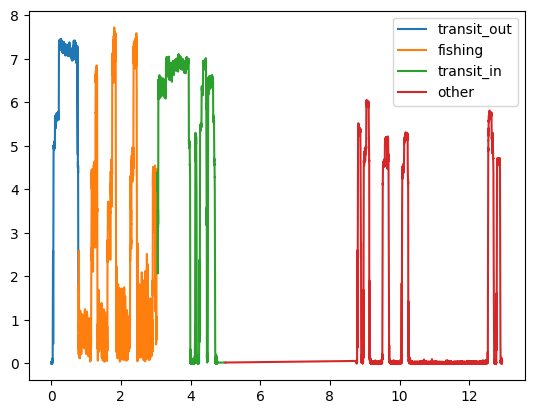

In [3]:
fig, ax = plt.subplots()
speed_profile = speed_profile_from_data(vessel=VESSEL, date=DATE)
if DATE in list(dates_fishing_modes):
    plot_profiles(
        ax,
        transit_out=speed_profile[
            np.logical_and(
                speed_profile[:, 0] > dates_fishing_modes[DATE]["transit_out"][0],
                speed_profile[:, 0] <= dates_fishing_modes[DATE]["transit_out"][1],
            ),
            :,
        ],
        fishing=speed_profile[
            np.logical_and(
                speed_profile[:, 0] > dates_fishing_modes[DATE]["fishing"][0],
                speed_profile[:, 0] <= dates_fishing_modes[DATE]["fishing"][1],
            ),
            :,
        ],
        transit_in=speed_profile[
            np.logical_and(
                speed_profile[:, 0] > dates_fishing_modes[DATE]["transit_in"][0],
                speed_profile[:, 0] <= dates_fishing_modes[DATE]["transit_in"][1],
            ),
            :,
        ],
    )
    if "other" in list(dates_fishing_modes[DATE].keys()):
        plot_profiles(
            ax,
            other=speed_profile[
                np.logical_and(
                    speed_profile[:, 0] > dates_fishing_modes[DATE]["other"][0],
                    speed_profile[:, 0] < dates_fishing_modes[DATE]["other"][1],
                ),
                :,
            ],
        )
else:
    plot_speed_profile(speed_profile=speed_profile, ax=ax)

ax.legend()

### Automatic operational modes

Distances and time:
	Transit out: 4.86 nm, 0.78 h, [0.00,0.78]
	Fishing: 11.10 nm, 3.49 h, [0.78,4.27]
	Transit in: 7.22 nm, 8.68 h, [4.27,12.94]



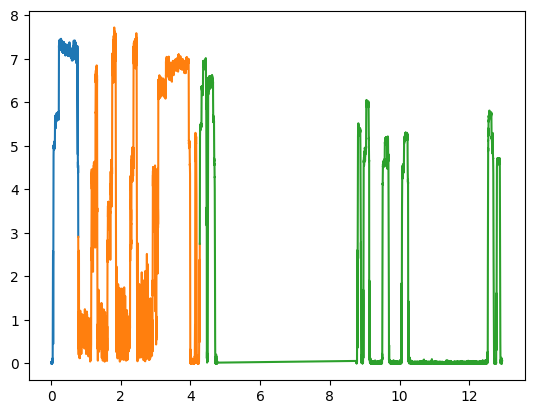

In [4]:
fig, ax = plt.subplots()
transit_out, fishing, transit_in = extract_transit_speed(speed_profile=speed_profile)
plot_profiles(ax, transit_out=transit_out, fishing=fishing, transit_in=transit_in)

distance_out = distance_from_profile(transit_out)
distance_fishing = distance_from_profile(fishing)
distance_in = distance_from_profile(transit_in)

time_out = transit_out[-1, 0] - transit_out[0, 0]
time_fishing = fishing[-1, 0] - fishing[0, 0]
time_in = transit_in[-1, 0] - transit_in[0, 0]

print(
    f"Distances and time:\n\tTransit out: {distance_out:.2f} nm, {time_out:.2f} h, [{transit_out[0,0]:.2f},{transit_out[-1, 0]:.2f}]\n\tFishing: {distance_fishing:.2f} nm, {time_fishing:.2f} h, [{fishing[0,0]:.2f},{fishing[-1, 0]:.2f}]\n\tTransit in: {distance_in:.2f} nm, {time_in:.2f} h, [{transit_in[0,0]:.2f},{transit_in[-1, 0]:.2f}]\n"
)

### Power profile and consumption for the DATE

Consumption propulsion: 60.47 kWh
Corrected consumption propulsion: 67.17 kWh


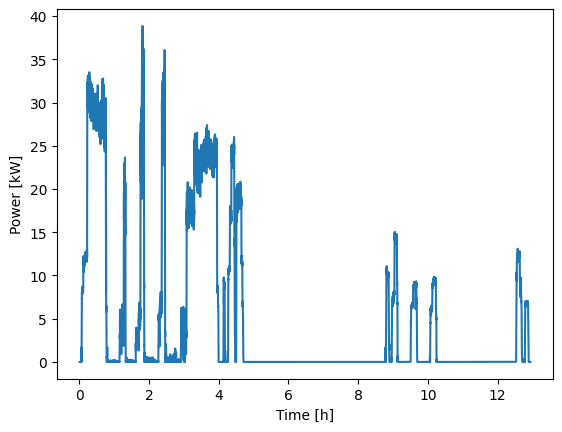

In [5]:
fig, ax = plt.subplots()
power_profile = components_to_profile(
    speed_profile[:, 0],
    calculate_propulsion_power(length=LENGTH, beam=BEAM, speeds=speed_profile[:, 1]),
)
plot_profiles(ax, power_profile=power_profile)
ax.set_ylabel("Power [kW]")
ax.set_xlabel("Time [h]")

corrected_power_profile = components_to_profile(
    power_profile[:, 0], power_profile[:, 1] * 1.1108
)
propulsion_total = total_consumption_from_profile(power_profile)
corrected_propulsion_total = total_consumption_from_profile(corrected_power_profile)

print(f"Consumption propulsion: {propulsion_total:.2f} kWh")
print(f"Corrected consumption propulsion: {corrected_propulsion_total:.2f} kWh")

### All days fishing

In [6]:
from pathlib import Path

from py_fish.engine import EngineApplication, calculate_consumption
from py_fish.loads import calculate_dc_energy, calculate_hydraulics_energy

data_dir = Path(os.path.abspath("")).resolve() / "py_fish" / "mira"
files = [f for f in data_dir.iterdir() if f.is_file()]
output = open("mira_consumptions_fishing.csv", "w")
output.write(
    "date,propulsion,propulsion_fit,hydraulics,dc,total,total_fit,kwh,kwh_fit\n"
)
output.close()
output = open("mira_consumptions_fishing.csv", "a")
for file in files:
    date = file.name[3:13]
    if date not in dates_fishing:
        continue
    measured_speed_profile = speed_profile_from_data(vessel=VESSEL, date=date)
    (transit_out, fishing, transit_in) = extract_transit_speed(measured_speed_profile)
    time_fishing = fishing[-1, 0] - fishing[0, 0]

    model_power = calculate_propulsion_power(
        speeds=uniform_filter1d(measured_speed_profile[:, 1], size=30),
        length=LENGTH,
        beam=BEAM,
    )

    power_increase = 1.1108

    model_power_fit = model_power * power_increase

    model_power_total = total_consumption_from_profile(
        components_to_profile(measured_speed_profile[:, 0], model_power)
    )
    model_power_total_fit = total_consumption_from_profile(
        components_to_profile(measured_speed_profile[:, 0], model_power_fit)
    )
    model_consumption_profile = components_to_profile(
        measured_speed_profile[:, 0],
        calculate_consumption(
            powers=model_power,
            engine_rating=ENGINE_RATING,
            engine_application=EngineApplication.PROPULSION,
        ),
    )
    model_consumption_profile_fit = components_to_profile(
        measured_speed_profile[:, 0],
        calculate_consumption(
            powers=model_power_fit,
            engine_rating=ENGINE_RATING,
            engine_application=EngineApplication.PROPULSION,
        ),
    )
    model_consumption_propulsion = total_consumption_from_profile(
        model_consumption_profile
    )
    model_consumption_propulsion_fit = total_consumption_from_profile(
        model_consumption_profile_fit
    )
    power_hydraulics = calculate_hydraulics_energy(hours_fishing=time_fishing)
    power_dc = calculate_dc_energy(
        hours_total=measured_speed_profile[-1, 0] - measured_speed_profile[0, 0]
    )
    hydraulics_consumption = calculate_consumption(
        powers=power_hydraulics,
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION_ZERO_IDLE,
    )
    dc_consumption = calculate_consumption(
        powers=power_dc,
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION_ZERO_IDLE,
    )
    output.write(
        f"{date},{model_consumption_propulsion},{model_consumption_propulsion_fit},{hydraulics_consumption},{dc_consumption},{model_consumption_propulsion + hydraulics_consumption + dc_consumption},{model_consumption_propulsion_fit + hydraulics_consumption + dc_consumption},{(model_power_total + power_dc + power_hydraulics)},{(model_power_total_fit + power_dc + power_hydraulics)}\n"
    )

output.close()

### All days not fishing

In [7]:
output = open("mira_consumptions.csv", "w")
output.write("date,propulsion,propulsion_fit,dc,total,total_fit,kwh,kwh_fit\n")
output.close()
output = open("mira_consumptions.csv", "a")
for file in files:
    date = file.name[3:13]
    if date in dates_fishing:
        continue
    measured_speed_profile = speed_profile_from_data(vessel=VESSEL, date=date)

    model_power = calculate_propulsion_power(
        speeds=uniform_filter1d(measured_speed_profile[:, 1], size=30),
        length=LENGTH,
        beam=BEAM,
    )

    power_increase = 1.1108

    model_power_fit = model_power * power_increase

    model_power_total = total_consumption_from_profile(
        components_to_profile(measured_speed_profile[:, 0], model_power)
    )
    model_power_total_fit = total_consumption_from_profile(
        components_to_profile(measured_speed_profile[:, 0], model_power_fit)
    )
    model_consumption_profile = components_to_profile(
        measured_speed_profile[:, 0],
        calculate_consumption(
            powers=model_power,
            engine_rating=ENGINE_RATING,
            engine_application=EngineApplication.PROPULSION,
        ),
    )
    model_consumption_profile_fit = components_to_profile(
        measured_speed_profile[:, 0],
        calculate_consumption(
            powers=model_power_fit,
            engine_rating=ENGINE_RATING,
            engine_application=EngineApplication.PROPULSION,
        ),
    )
    model_consumption_propulsion = total_consumption_from_profile(
        model_consumption_profile
    )
    model_consumption_propulsion_fit = total_consumption_from_profile(
        model_consumption_profile_fit
    )

    power_dc = calculate_dc_energy(
        hours_total=measured_speed_profile[-1, 0] - measured_speed_profile[0, 0]
    )
    dc_consumption = calculate_consumption(
        powers=power_dc,
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION_ZERO_IDLE,
    )
    output.write(
        f"{date},{model_consumption_propulsion},{model_consumption_propulsion_fit},{dc_consumption},{model_consumption_propulsion + dc_consumption},{model_consumption_propulsion_fit + dc_consumption},{(model_power_total + power_dc)},{(model_power_total_fit + power_dc)}\n"
    )

output.close()

### Representative date and profiles

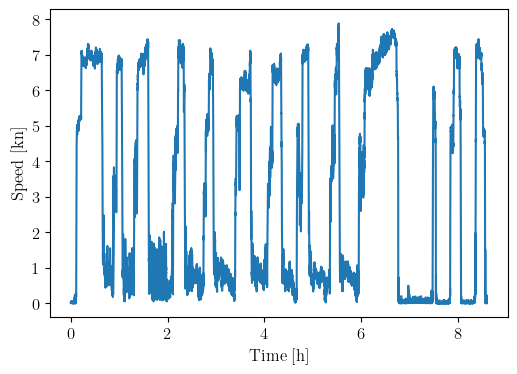

In [8]:
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 12})

REPRESENTATIVE_DATE = "2024-04-22"


representative_speed_profile = speed_profile_from_data(
    vessel=VESSEL, date=REPRESENTATIVE_DATE
)



fig, ax = plt.subplots(figsize=(5.90666, 4))


plot_speed_profile(ax=ax, speed_profile=representative_speed_profile)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


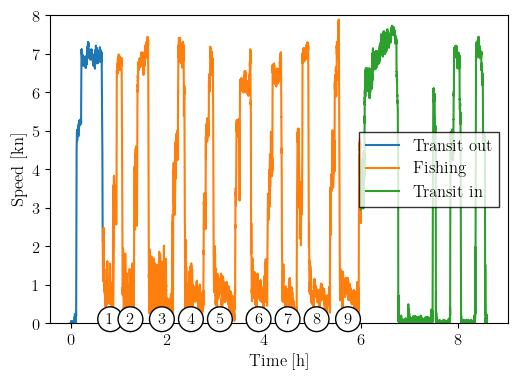

In [9]:
fig, ax = plt.subplots(figsize=(5.90666, 4))
transit_out = representative_speed_profile[
    np.logical_and(
        representative_speed_profile[:, 0]
        > dates_fishing_modes[REPRESENTATIVE_DATE]["transit_out"][0],
        representative_speed_profile[:, 0]
        <= dates_fishing_modes[REPRESENTATIVE_DATE]["transit_out"][1],
    ),
    :,
]
fishing = representative_speed_profile[
    np.logical_and(
        representative_speed_profile[:, 0]
        > dates_fishing_modes[REPRESENTATIVE_DATE]["fishing"][0],
        representative_speed_profile[:, 0]
        <= dates_fishing_modes[REPRESENTATIVE_DATE]["fishing"][1],
    ),
    :,
]
transit_in = representative_speed_profile[
    np.logical_and(
        representative_speed_profile[:, 0]
        > dates_fishing_modes[REPRESENTATIVE_DATE]["transit_in"][0],
        representative_speed_profile[:, 0]
        <= dates_fishing_modes[REPRESENTATIVE_DATE]["transit_in"][1],
    ),
    :,
]
plot_profiles(
    ax,
    transit_out=transit_out,
    fishing=fishing,
    transit_in=transit_in,
)
xpos = [0.73, 1.15, 1.8, 2.4, 3.0, 3.8, 4.4, 5.0, 5.65]
annotations = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]
pad = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]

for xi, text, padi in zip(xpos, annotations, pad):

    ax.text(xi, 0, text, bbox=dict(boxstyle="circle", fc="white", pad=padi))


ax.set_xlabel("Time [h]")
ax.set_ylabel("Speed [kn]")
ax.set_ylim([0, 8])
lgd = ax.legend(["Transit out", "Fishing", "Transit in"], loc=7)
lgd.get_frame().set_edgecolor("k")
lgd.get_frame().set_boxstyle("square", pad=0.0)
fig.savefig(
    "figures/mira_representative_speed_profile.eps",
    format="eps",
)

In [10]:
df = load_one_day(vessel=VESSEL, date=REPRESENTATIVE_DATE)
coordinates = df.select(["time", "speed", "latitude", "longitude"]).to_numpy()
coordinates[:, 0] = (coordinates[:, 0] - coordinates[0, 0]) / (3600 * 1e6)

transit_out_coordinates = coordinates[
    np.logical_and(
        coordinates[:, 0] >= transit_out[0, 0], coordinates[:, 0] <= transit_out[-1, 0]
    ),
    :,
]
transit_in_coordinates = coordinates[
    np.logical_and(
        coordinates[:, 0] >= transit_in[0, 0], coordinates[:, 0] <= transit_in[-1, 0]
    ),
    :,
]
fishing_coordinates = coordinates[
    np.logical_and(
        coordinates[:, 0] >= fishing[0, 0], coordinates[:, 0] <= fishing[-1, 0]
    ),
    :,
]
m = folium.Map(
    location=coordinates[0, 2:],
    control_scale=True,
    zoom_start=12,
    min_zoom=12,
    tiles="cartodb positron",
)
folium.PolyLine(
    transit_in_coordinates[:, 2:], tooltip="Transit in", color="#2ca02c"
).add_to(m)
folium.PolyLine(
    transit_out_coordinates[:, 2:], tooltip="Transit out", color="#1f77b4"
).add_to(m)
folium.PolyLine(fishing_coordinates[:, 2:], tooltip="Fishing", color="#ff7f0e").add_to(
    m
)
for i in xpos:
    pot = fishing_coordinates[fishing_coordinates[:, 0] > i, :][0][2:]

    folium.CircleMarker(location=pot, radius=6.0, color="black").add_to(m)

m

### Map

In [11]:
df = load_one_day(vessel=VESSEL, date=REPRESENTATIVE_DATE)
coordinates = df.select(["time", "latitude", "longitude", "speed"]).to_numpy()
coordinates[:, 0] = (coordinates[:, 0] - coordinates[0, 0]) / (3600 * 1e6)

m = folium.Map(
    location=coordinates[0, 1:3],
    control_scale=True,
    # zoom_start=12,
    # min_zoom=12,
    tiles="cartodb positron",
)
import branca.colormap as cm

step = cm.StepColormap(
    ["green", "yellow", "red"],
    vmin=0,
    vmax=10,
    index=[0, 3.0, 6.0, 9.0],
    caption="step",
)
step.caption = "Speed [kn]"


folium.ColorLine(
    coordinates[:, [1, 2]],
    colors=coordinates[:, 3],
    colormap=step,
    weight=5,
).add_to(m)
m.add_child(step)
m

### Operational modes

In [12]:
data_dir = Path(os.path.abspath("")).resolve() / "py_fish" / "mira"
files = [f for f in data_dir.iterdir() if f.is_file()]
output = open("mira_operation.csv", "w")
output.write(
    "date,distance_out,distance_fishing,distance_in,distance_total,time_out,time_fishing,time_in,time_total,num_strings\n"
)
output.close()
output = open("mira_operation.csv", "a")
for file in files:
    DATE = file.name[3:13]
    if DATE not in list(dates_fishing_modes.keys()):
        continue
    measured_speed_profile = speed_profile_from_data(vessel=VESSEL, date=DATE)
    transit_out = measured_speed_profile[
    np.logical_and(
        measured_speed_profile[:, 0]
        > dates_fishing_modes[DATE]["transit_out"][0],
        measured_speed_profile[:, 0]
        <= dates_fishing_modes[DATE]["transit_out"][1],
    ),
    :,
        ]
    fishing = measured_speed_profile[
        np.logical_and(
            measured_speed_profile[:, 0]
            > dates_fishing_modes[DATE]["fishing"][0],
            measured_speed_profile[:, 0]
            <= dates_fishing_modes[DATE]["fishing"][1],
        ),
        :,
    ]
    transit_in = measured_speed_profile[
        np.logical_and(
            measured_speed_profile[:, 0]
            > dates_fishing_modes[DATE]["transit_in"][0],
            measured_speed_profile[:, 0]
            <= dates_fishing_modes[DATE]["transit_in"][1],
        ),
        :,
    ]
    distance_out = distance_from_profile(transit_out)
    distance_fishing = distance_from_profile(fishing)
    distance_in = distance_from_profile(transit_in)
    distance_total = distance_out + distance_fishing + distance_in
    time_out = transit_out[-1, 0] - transit_out[0,0]
    time_fishing = fishing[-1, 0] - fishing[0, 0]
    time_in = transit_in[-1, 0] - transit_in[0,0]
    time_total = time_out + time_fishing + time_in

    output.write(
        f"{DATE},{distance_out},{distance_fishing},{distance_in},{distance_total},{time_out},{time_fishing},{time_in},{time_total},{dates_fishing_modes[DATE]["pots"]}\n"
    )
output.close()

In [37]:
df_op = pl.read_csv("mira_operation.csv")
means = df_op.describe().row(by_predicate=pl.col("statistic") == "mean", named=True)
print(means)
means["distance_out"]

times = np.array([means["time_out"], means["time_fishing"], means["time_in"]])
print(np.round(times / means["time_total"] * 100.0, 1))

distances = np.array(
    [means["distance_out"], means["distance_fishing"], means["distance_in"]]
)
print(np.round(distances / means["distance_total"] * 100.0, 1))

{'statistic': 'mean', 'date': None, 'distance_out': 5.267464158124012, 'distance_fishing': 10.527930418151856, 'distance_in': 6.498959340549884, 'distance_total': 22.29435391682575, 'time_out': 0.9247222222222221, 'time_fishing': 4.59329365079365, 'time_in': 1.9901984126984122, 'time_total': 7.508214285714286, 'num_strings': 7.571428571428571}
[12.3 61.2 26.5]
[23.6 47.2 29.2]
